In [ ]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append("pconv")
sys.path.append("MonarchCircuits")
import pyjuice
from src.dataset import ImageNet
from src.utils import patchify
import matplotlib.pyplot as plt
import torch
from src.colours import Rgb2YccLossy, Rgb2GenT
import numpy as np
import pandas as pd
from pc_mini_em.src.transforms.color_trans import RGB2YCoCgR, YCoCg2RGB

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
!ls -l -h datasets/ImageNet/imagenet32/val

total 134M
-rw-r--r-- 1 s2893001 people 134M Sep  1  2019 val_data.npz


In [ ]:
class Rgb2GenTChannel(object):

    def __call__(self, rgb_images: torch.Tensor):
        assert rgb_images.size(-1) == 3

        def forward_lift(x, y):
            diff = (y - x) % 256
            average = (x + (diff >> 1)) % 256
            return average, diff

        red, green, blue = rgb_images[..., 0], rgb_images[..., 1], rgb_images[..., 2]
        temp, co = forward_lift(red, blue)
        y, cg = forward_lift(green, temp)
        ycc_images = torch.stack([y, co, cg], dim=-1)
        return ycc_images

In [ ]:
ours_color=Rgb2GenT()
ours_color_last=Rgb2GenTChannel()

theirs = RGB2YCoCgR()
theirs_scale = RGB2YCoCgR(rgb_range=(0,255))
return_rgb = YCoCg2RGB()

In [16]:
images.shape

torch.Size([50000, 3, 64, 64])

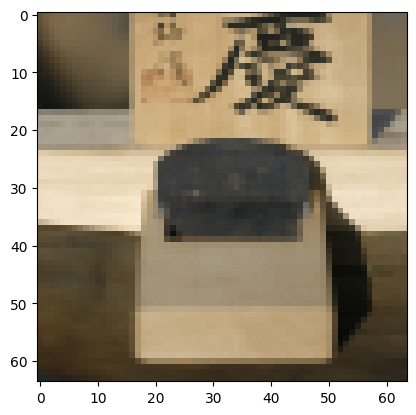

In [20]:
data = torch.load("pconv/datasets/imagenet/imagenet64_val.pt", mmap=True)
if isinstance(data, dict):
    images = (data["image"]).view(-1, 3, 64, 64).long()
images.shape, images.dtype
plt.imshow(images[0].permute(1, 2, 0))

In [22]:
our_tsf = ours_color(images[0])
their_tsf = theirs_scale(images[0])
returned = return_rgb(their_tsf)

In [24]:
images[0]

tensor([[[102, 115, 123,  ..., 111, 109, 108],
         [ 99, 112, 124,  ..., 111, 111, 110],
         [ 95, 109, 120,  ..., 112, 112, 112],
         ...,
         [ 54,  56,  56,  ...,  47,  45,  44],
         [ 40,  45,  46,  ...,  46,  49,  50],
         [ 30,  33,  35,  ...,  47,  46,  47]],

        [[ 84,  94, 100,  ..., 103, 102, 101],
         [ 81,  93, 100,  ..., 102, 102, 102],
         [ 78,  90, 100,  ..., 103, 103, 103],
         ...,
         [ 40,  41,  41,  ...,  39,  38,  38],
         [ 40,  39,  36,  ...,  39,  41,  42],
         [ 38,  39,  38,  ...,  41,  40,  39]],

        [[ 54,  63,  69,  ...,  87,  86,  85],
         [ 53,  62,  71,  ...,  86,  86,  86],
         [ 52,  62,  70,  ...,  85,  86,  85],
         ...,
         [ 23,  23,  24,  ...,  28,  27,  26],
         [ 31,  27,  24,  ...,  28,  30,  30],
         [ 41,  40,  36,  ...,  28,  29,  28]]])

In [23]:
returned

tensor([[[102,  84,  54],
         [115,  94,  63],
         [123, 100,  69],
         ...,
         [111, 103,  87],
         [109, 102,  86],
         [108, 101,  85]],

        [[ 99,  81,  53],
         [112,  93,  62],
         [124, 100,  71],
         ...,
         [111, 102,  86],
         [111, 102,  86],
         [110, 102,  86]],

        [[ 95,  78,  52],
         [109,  90,  62],
         [120, 100,  70],
         ...,
         [112, 103,  85],
         [112, 103,  86],
         [112, 103,  85]],

        ...,

        [[ 54,  40,  23],
         [ 56,  41,  23],
         [ 56,  41,  24],
         ...,
         [ 47,  39,  28],
         [ 45,  38,  27],
         [ 44,  38,  26]],

        [[ 40,  40,  31],
         [ 45,  39,  27],
         [ 46,  36,  24],
         ...,
         [ 46,  39,  28],
         [ 49,  41,  30],
         [ 50,  42,  30]],

        [[ 30,  38,  41],
         [ 33,  39,  40],
         [ 35,  38,  36],
         ...,
         [ 47,  41,  28],
        

In [17]:
their_tsf

tensor([[[-111, -101,  -94,  ...,  -91,  -93,  -94],
         [-114, -102,  -94,  ...,  -92,  -92,  -92],
         [-117, -105,  -95,  ...,  -92,  -91,  -92],
         ...,
         [-153, -152, -152,  ..., -154, -155, -156],
         [-155, -155, -157,  ..., -154, -152, -151],
         [-156, -155, -156,  ..., -153, -154, -154]],

        [[ 304,  308,  310,  ...,  280,  279,  279],
         [ 302,  306,  309,  ...,  281,  281,  280],
         [ 299,  303,  306,  ...,  283,  282,  283],
         ...,
         [ 287,  289,  288,  ...,  275,  274,  274],
         [ 265,  274,  278,  ...,  274,  275,  276],
         [ 245,  249,  255,  ...,  275,  273,  275]],

        [[-122, -123, -124,  ..., -124, -123, -123],
         [-123, -122, -125,  ..., -124, -124, -124],
         [-123, -123, -123,  ..., -123, -124, -123],
         ...,
         [-126, -126, -127,  ..., -126, -126, -125],
         [-123, -125, -127,  ..., -126, -126, -126],
         [-125, -125, -125,  ..., -124, -125, -126]]]

In [32]:
their_tsf

tensor([[[ 81,  91,  98,  ..., 101,  99,  98],
         [ 78,  90,  98,  ..., 100, 100, 100],
         [ 75,  87,  97,  ..., 100, 101, 100],
         ...,
         [ 39,  40,  40,  ...,  38,  37,  36],
         [ 37,  37,  35,  ...,  38,  40,  41],
         [ 36,  37,  36,  ...,  39,  38,  38]],

        [[304, 308, 310,  ..., 280, 279, 279],
         [302, 306, 309,  ..., 281, 281, 280],
         [299, 303, 306,  ..., 283, 282, 283],
         ...,
         [287, 289, 288,  ..., 275, 274, 274],
         [265, 274, 278,  ..., 274, 275, 276],
         [245, 249, 255,  ..., 275, 273, 275]],

        [[262, 261, 260,  ..., 260, 261, 261],
         [261, 262, 259,  ..., 260, 260, 260],
         [261, 261, 261,  ..., 261, 260, 261],
         ...,
         [258, 258, 257,  ..., 258, 258, 259],
         [261, 259, 257,  ..., 258, 258, 258],
         [259, 259, 259,  ..., 260, 259, 258]]])

Text(0.5, 1.0, 'Reverse monarch Transform (channel 2)')

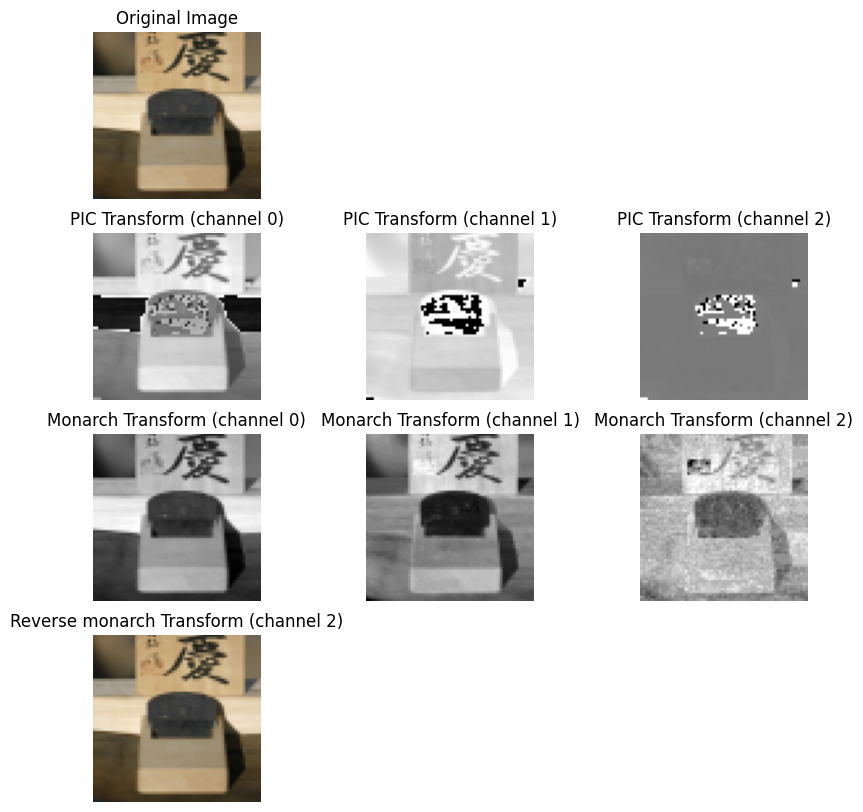

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(4,3,1)
plt.imshow(images[0].permute(1, 2, 0))
plt.axis("off")
plt.title("Original Image")

for channel in range(3):
    plt.subplot(4,3,4+channel)
    plt.imshow(ours_color_last(images[0].to(torch.int16).permute(1, 2, 0))[:,:,channel:channel+1], cmap="gray")
    plt.axis("off")
    plt.title(f"PIC Transform (channel {channel})")


for channel in range(3):
    plt.subplot(4,3,7+channel)
    plt.imshow(theirs_scale(images[0])[channel:channel+1].permute(1, 2, 0), cmap="gray")
    plt.axis("off")
    plt.title(f"Monarch Transform (channel {channel})")


def return_rgb(x):
    Y,Co,Cg = x[0,:, :], x[1,:, :], x[2,:, :]
    Co-=256
    Cg-=256

    tmp = Y - Cg//2
    G2   = Cg + tmp
    B2   = tmp - Co//2
    R2   = B2 + Co
    return torch.stack([R2,G2,B2], dim=2)

plt.subplot(4,3,10)
plt.imshow(return_rgb(theirs_scale(images[0])))
plt.axis("off")
plt.title(f"Reverse monarch Transform (channel {channel})")
images[0]
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1147..29452].


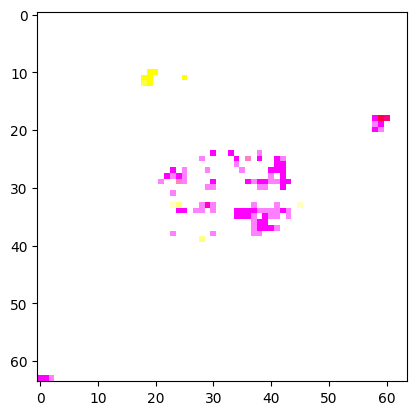

In [29]:
plt.imshow(theirs_scale(images[0]).permute(1, 2, 0))


torch.Size([3, 64, 64])
torch.int64


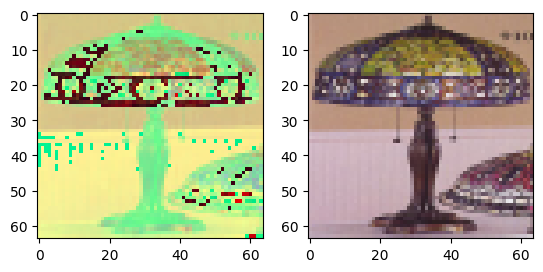

In [ ]:
ds = ImageNet("datasets", colour_transform=Rgb2GenT())
ds.setup("t")
dataloader = ds.train_dataloader()

back = Ycc2RgbLossless()
img = next(iter(dataloader))[0]
plt.subplot(121)
plt.imshow(img.permute(1, 2, 0))
plt.subplot(122)
plt.imshow(back(img).permute(1, 2, 0))

In [ ]:
images[0]

tensor([[[102, 115, 123,  ..., 111, 109, 108],
         [ 99, 112, 124,  ..., 111, 111, 110],
         [ 95, 109, 120,  ..., 112, 112, 112],
         ...,
         [ 54,  56,  56,  ...,  47,  45,  44],
         [ 40,  45,  46,  ...,  46,  49,  50],
         [ 30,  33,  35,  ...,  47,  46,  47]],

        [[ 84,  94, 100,  ..., 103, 102, 101],
         [ 81,  93, 100,  ..., 102, 102, 102],
         [ 78,  90, 100,  ..., 103, 103, 103],
         ...,
         [ 40,  41,  41,  ...,  39,  38,  38],
         [ 40,  39,  36,  ...,  39,  41,  42],
         [ 38,  39,  38,  ...,  41,  40,  39]],

        [[ 54,  63,  69,  ...,  87,  86,  85],
         [ 53,  62,  71,  ...,  86,  86,  86],
         [ 52,  62,  70,  ...,  85,  86,  85],
         ...,
         [ 23,  23,  24,  ...,  28,  27,  26],
         [ 31,  27,  24,  ...,  28,  30,  30],
         [ 41,  40,  36,  ...,  28,  29,  28]]], dtype=torch.uint8)

In [ ]:
ds.imnet_test.transform(images[0])

tensor([[[154, 141, 133,  ..., 145, 147, 148],
         [157, 144, 132,  ..., 145, 145, 146],
         [161, 147, 136,  ..., 144, 144, 144],
         ...,
         [202, 200, 200,  ..., 209, 211, 212],
         [216, 211, 210,  ..., 210, 207, 206],
         [226, 223, 221,  ..., 209, 210, 209]],

        [[172, 162, 156,  ..., 153, 154, 155],
         [175, 163, 156,  ..., 154, 154, 154],
         [178, 166, 156,  ..., 153, 153, 153],
         ...,
         [216, 215, 215,  ..., 217, 218, 218],
         [216, 217, 220,  ..., 217, 215, 214],
         [218, 217, 218,  ..., 215, 216, 217]],

        [[202, 193, 187,  ..., 169, 170, 171],
         [203, 194, 185,  ..., 170, 170, 170],
         [204, 194, 186,  ..., 171, 170, 171],
         ...,
         [233, 233, 232,  ..., 228, 229, 230],
         [225, 229, 232,  ..., 228, 226, 226],
         [215, 216, 220,  ..., 228, 227, 228]]])

torch.Size([3, 64, 64])
ehoh


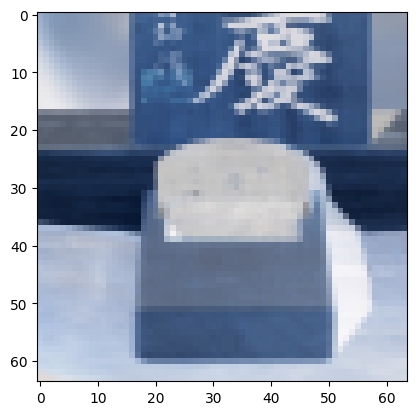

In [ ]:
plt.imshow(ds.imnet_test[0].permute(1, 2, 0))